In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shutil

In [2]:
from pydub import AudioSegment

c:\Users\acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def dummy(data,numarr):
    new_data =[]
    for i in data:
        lab_data = []
        for j in range(0,numarr):
            lab_data.append(0)
        #lab_data =[0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [4]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [5]:

def createdict(num):
    lab_data = []
    for i in range(0,num):
        lab_data.append(i)
    dic = dict.fromkeys(lab_data, 0)
    return dic

In [6]:
def createWeight(class_count,num_classes):
    class_weights = createdict(num_classes)
    for i in range(num_classes):
        class_weights[i]=create_weight(np.sum(class_count),num_classes,class_count[i])
    return class_weights

In [7]:
def preprocess(data_dir,numclass):
    data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='int', image_size=(432, 288), seed=321,
    validation_split=None, subset=None)
    class_names = data_ds.class_names
    
    feature=[]
    label=[]
    for images, labels in data_ds.unbatch().take(-1):
        feature.append(images.numpy())
        label.append(labels.numpy())
        
    x_train,x_test,y_train,y_test = train_test_split(feature,label,test_size = 0.20,random_state =101)
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    
    class_count=[]
    for i in range(0,numclass):
        class_count.append(np.count_nonzero(y_train == i))
    class_count = np.array(class_count)
    y_train = dummy(y_train,numclass)
    y_test = dummy(y_test,numclass)
    class_weights = createWeight(class_count,numclass)
   
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return x_train,x_test,y_train,y_test,class_weights,class_names
    

In [8]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(type_classification_directory,2)

Found 248 files belonging to 2 classes.


In [9]:
def categories2binary(categories):
    binarydata = []
    for item in categories:
        binarydata.append(item[0])
    binarydata=np.array(binarydata)
    return(binarydata)

In [10]:
def binary2categories(binary):
    new_data = []
    for i in binary:
        lab_data = []
        for j in range(0,2):
            lab_data.append(0)
        if(i>=0.5):
            lab_data[1]=1;
        elif(i<0.5):
            lab_data[0]=1;
        new_data.append(lab_data)
    new_data = np.array(new_data)
    return(new_data)

In [11]:
split_class_base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
split_class_base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = split_class_base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
split_class_model = tf.keras.Model(inputs, outputs)

split_class_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 432, 288, 3)       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d (Conv2D)             (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 4, 128)        0         
 2D)                                                             
                                                             

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 28s 5s/step - loss: 0.7139 - accuracy: 0.6203 - val_loss: 0.4998 - val_accuracy: 0.7250
Epoch 2/100
5/5 [==============================] - 19s 4s/step - loss: 0.4590 - accuracy: 0.7722 - val_loss: 0.4223 - val_accuracy: 0.8500
Epoch 3/100
5/5 [==============================] - 19s 4s/step - loss: 0.4418 - accuracy: 0.8038 - val_loss: 0.3681 - val_accuracy: 0.8250
Epoch 4/100
5/5 [==============================] - 18s 4s/step - loss: 0.3899 - accuracy: 0.8544 - val_loss: 0.3677 - val_accuracy: 0.8500
Epoch 5/100
5/5 [==============================] - 18s 4s/step - loss: 0.2756 - accuracy: 0.8924 - val_loss: 0.3799 - val_accuracy: 0.8750
Epoch 6/100
5/5 [==============================] - 18s 4s/step - loss: 0.2891 - accuracy: 0.8987 - val_loss: 0.3197 - val_accuracy: 0.8750
Epoch 7/100
5/5 [==============================] - 18s 4s/step - loss: 0.2659 - accuracy: 0.8861 - val_loss: 0.3124 - val_accuracy: 0.9000
Epoch 8/100
5/5 [======================

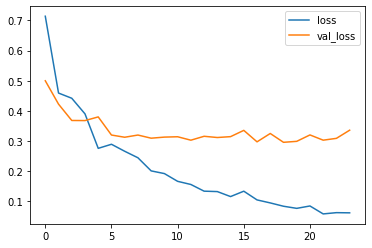

In [12]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-4)# modify weight in Adam
metrics = ['accuracy']
split_class_model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = split_class_model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()



[0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 0]
                          precision    recall  f1-score   support

HungryTiredAndDiscomfort       0.91      0.97      0.94        30
             burpAndPoop       0.94      0.85      0.89        20

                accuracy                           0.92        50
               macro avg       0.93      0.91      0.92        50
            weighted avg       0.92      0.92      0.92        50



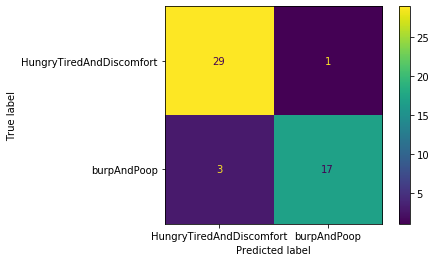

In [13]:
pred = split_class_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [14]:
split_class_model.save('./h5_model/split_class_model.h5')

In [15]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(burpAndPoop_directory,2)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/img_data/dustan/burpAndPoop/mel_spectrogram/'

In [ ]:
burpAndPoop_base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
burpAndPoop_base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = burpAndPoop_base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
burpAndPoop_model = tf.keras.Model(inputs, outputs)

burpAndPoop_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_3 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 12s 3s/step - loss: 7.1199 - accuracy: 0.5821 - val_loss: 4.1904 - val_accuracy: 0.6471
Epoch 2/100
3/3 [==============================] - 8s 2s/step - loss: 3.8018 - accuracy: 0.5224 - val_loss: 0.4248 - val_accuracy: 0.8824
Epoch 3/100
3/3 [==============================] - 8s 2s/step - loss: 0.4558 - accuracy: 0.8507 - val_loss: 0.6130 - val_accuracy: 0.5882
Epoch 4/100
3/3 [==============================] - 8s 2s/step - loss: 0.5337 - accuracy: 0.6866 - val_loss: 0.7130 - val_accuracy: 0.4118
Epoch 5/100
3/3 [==============================] - 8s 2s/step - loss: 0.5667 - accuracy: 0.5075 - val_loss: 0.7179 - val_accuracy: 0.4118
Epoch 6/100
3/3 [==============================] - 8s 2s/step - loss: 0.5669 - accuracy: 0.5224 - val_loss: 0.6684 - val_accuracy: 0.5294
Epoch 7/100
3/3 [==============================] - 8s 2s/step - loss: 0.5103 - accuracy: 0.6418 - val_loss: 0.6222 - val_accuracy: 0.5882
Epoch 1/50
2/2 [=============================

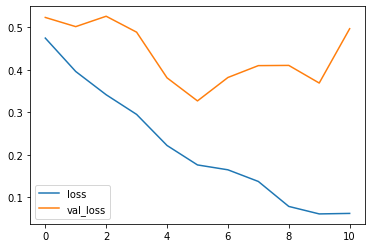

In [ ]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
burpAndPoop_model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = burpAndPoop_model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

burpAndPoop_base_model.trainable = True
burpAndPoop_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = burpAndPoop_model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()


[0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0]
              precision    recall  f1-score   support

     burping       1.00      1.00      1.00        13
        poop       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



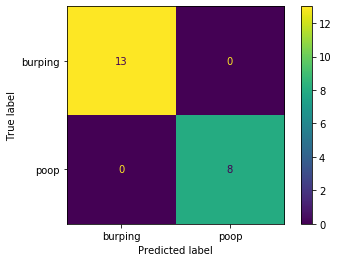

In [ ]:
pred = burpAndPoop_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1) 
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [ ]:
burpAndPoop_model.save('./h5_model/burpAndPoop.h5')

In [ ]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(HungryTiredAndDiscomfort_directory,3)

Found 143 files belonging to 3 classes.


In [ ]:
HungryTiredAndDiscomfort_base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
HungryTiredAndDiscomfort_base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = HungryTiredAndDiscomfort_base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)
HungryTiredAndDiscomfort_model = tf.keras.Model(inputs, outputs)

HungryTiredAndDiscomfort_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_4 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 18s 6s/step - loss: 10.6774 - accuracy: 0.3626 - val_loss: 10.3047 - val_accuracy: 0.2174
Epoch 2/100
3/3 [==============================] - 17s 6s/step - loss: 5.8038 - accuracy: 0.3956 - val_loss: 1.8148 - val_accuracy: 0.6087
Epoch 3/100
3/3 [==============================] - 16s 6s/step - loss: 1.1478 - accuracy: 0.5934 - val_loss: 1.0412 - val_accuracy: 0.5217
Epoch 4/100
3/3 [==============================] - 16s 6s/step - loss: 0.7530 - accuracy: 0.6044 - val_loss: 1.0096 - val_accuracy: 0.6087
Epoch 5/100
3/3 [==============================] - 17s 6s/step - loss: 0.7573 - accuracy: 0.5824 - val_loss: 0.8720 - val_accuracy: 0.6087
Epoch 6/100
3/3 [==============================] - 16s 6s/step - loss: 0.6454 - accuracy: 0.7253 - val_loss: 0.7669 - val_accuracy: 0.5652
Epoch 7/100
3/3 [==============================] - 15s 5s/step - loss: 0.6056 - accuracy: 0.7033 - val_loss: 0.7289 - val_accuracy: 0.5652
Epoch 8/100
3/3 [====================

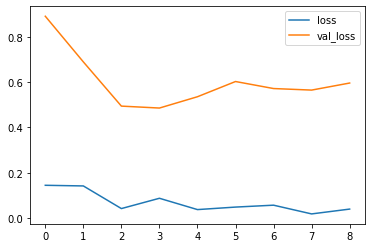

In [ ]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
HungryTiredAndDiscomfort_model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = HungryTiredAndDiscomfort_model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

HungryTiredAndDiscomfort_base_model.trainable = True
HungryTiredAndDiscomfort_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = HungryTiredAndDiscomfort_model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()


[2 2 0 0 2 1 2 0 2 1 1 2 1 1 0 1 1 1 2 2 0 1 0 1 1 1 1 1 2]
              precision    recall  f1-score   support

  discomfort       1.00      0.75      0.86         8
      hungry       0.57      0.89      0.70         9
       tired       0.89      0.67      0.76        12

    accuracy                           0.76        29
   macro avg       0.82      0.77      0.77        29
weighted avg       0.82      0.76      0.77        29



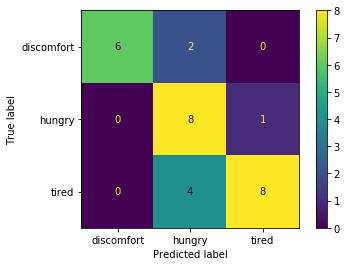

In [ ]:
pred = HungryTiredAndDiscomfort_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1) 
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [ ]:
HungryTiredAndDiscomfort_model.save('./h5_model/HungryTiredAndDiscomfort.h5')